In [1]:
import matplotlib.pyplot as plt
import numpy as np
import arviz as az
from jax.scipy.special import logsumexp
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter

import GWPhotonCounting

/home/ethan.payne/code_libraries/bilby/bilby/gw/detector/geometry.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import ROT_DAY, DAYJUL_SI
/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax.numpy as jnp
frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))

detector_CE1 = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE1_shot_psd_updated.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE1_classical_quanta_updated.csv', 
    gamma=100, random_seed=1632, N_frequency_spaces=10)


hierarchical_analysis = GWPhotonCounting.hierarchical.HierarchicalPostMerger(
    'results_250403b_CE1CE2silica/', detector=detector_CE1, Nevents=100,
    noise_directory='results_noise_only_250403b_CE1CE2silica/')

100%|██████████| 100/100 [01:56<00:00,  1.17s/it]


In [3]:
print(hierarchical_analysis.photon_count, hierarchical_analysis.photon_count_no_background)

results = hierarchical_analysis.generate_posterior()

15 0


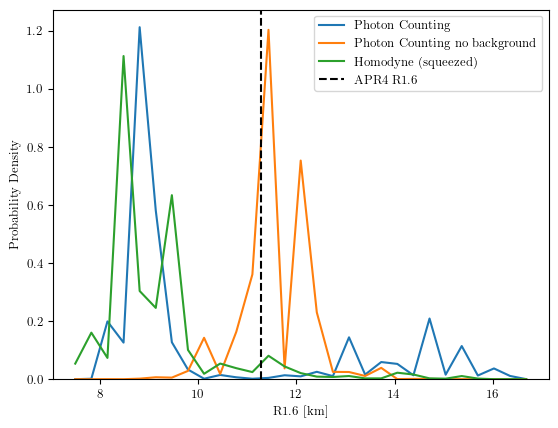

In [4]:
plt.plot(results[0][:-1], np.exp(results[1]-np.max(results[1]))/np.sum(np.exp(results[1]-np.max(results[1])))/np.diff(results[0])[0], label='Photon Counting')
plt.plot(results[0][:-1], np.exp(results[2]-np.max(results[2]))/np.sum(np.exp(results[2]-np.max(results[2])))/np.diff(results[0])[0], label='Photon Counting no background')
plt.plot(results[0][:-1], np.exp(results[3]-np.max(results[3]))/np.sum(np.exp(results[3]-np.max(results[3])))/np.diff(results[0])[0], label='Homodyne (squeezed)')
plt.ylabel('Probability Density')
plt.xlabel('R1.6 [km]')
plt.ylim(0,)
plt.axvline(11.27, color='k', linestyle='--', label='APR4 R1.6')
plt.legend()
plt.show()

(0.0, 0.0015576492461538457)

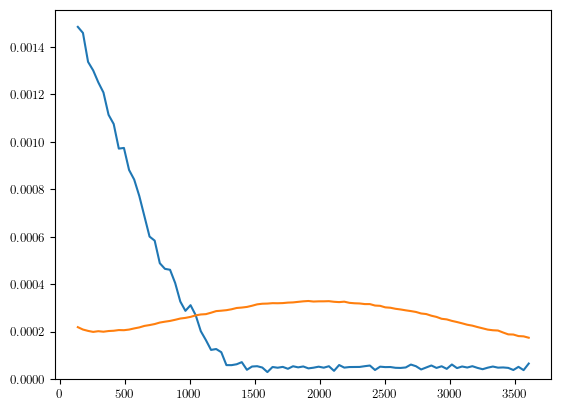

In [5]:
frequencies = jnp.linspace(1e2, 4e3, 100)
plt.plot(frequencies[1:90], np.exp(hierarchical_analysis.likelihood_noise_only_pc[1:90]))
plt.plot(frequencies[1:90], np.exp(hierarchical_analysis.likelihood_noise_only_strain[1:90]))
plt.ylim(0,)

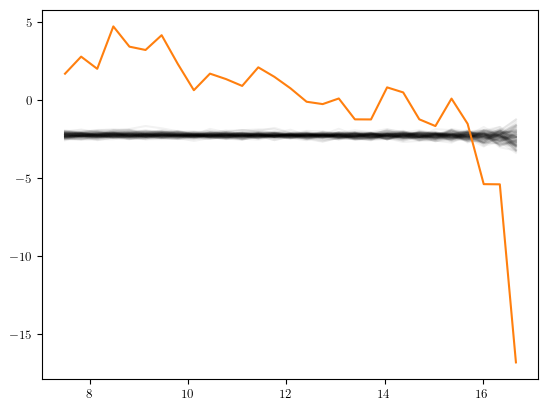

In [7]:

likelihoods =  hierarchical_analysis.likelihood_strain

plt.plot(results[0][:-1], jnp.array(likelihoods).T, label='Likelihood', color='k', alpha=0.05)
plt.plot(results[0][:-1], jnp.sum(jnp.array(likelihoods), axis=0) - jnp.mean(jnp.sum(jnp.array(likelihoods), axis=0)), label='Likelihood', color='C1')


plt.show()

In [8]:
np.argmin(np.min(jnp.array(likelihoods), axis=1))

Array(32, dtype=int64)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]


ValueError: x and y must have same first dimension, but have shapes (100,) and (29,)

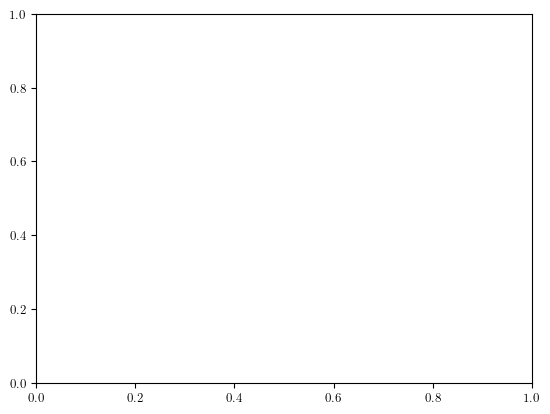

In [9]:
import jax.numpy as jnp
from scipy.interpolate import interp1d
from tqdm import tqdm

R1d6s = jnp.linspace(9, 15, 100)
plt.clf()
N = 10

for idx in tqdm(range(N)):

    plt.plot(R1d6s, np.exp(likelihoods[idx])/np.sum(np.exp(likelihoods[idx]))/(R1d6s[1] - R1d6s[0]), color='k', alpha=0.05)
    #plt.plot(R1d6s, likelihood_r1d6, color='k', alpha=0.05)


total_logl = jnp.sum(likelihoods[:N], axis=0)
total_logl -= jnp.max(total_logl)
plt.plot(R1d6s, np.exp(total_logl)/np.sum(np.exp(total_logl))/(R1d6s[1] - R1d6s[0]), color='C1', label='Total likelihood')

plt.ylim(0,)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


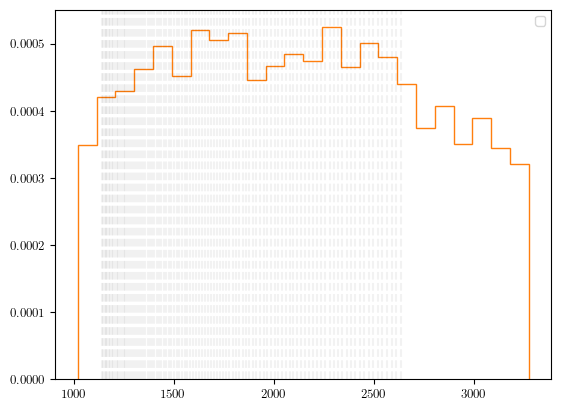

In [11]:
i = 32

file = f'results_250403b_CE1CE2silica/result_{1000 + i}_strain.nc'

data = az.from_netcdf(file)

model_frequencies = GWPhotonCounting.hierarchical.frequency_model(hierarchical_analysis.mtots[i], R1d6s)/(1+hierarchical_analysis.zs[i])
plt.hist(data.posterior.f0.values.flatten(), bins=np.linspace(np.min(data.posterior.f0.values.flatten()), np.max(data.posterior.f0.values.flatten()), 25), density=True, histtype='step', color='C1')
plt.legend()

for f in model_frequencies:
    plt.axvline(f, color='k', linestyle='--', alpha=0.05)
plt.show()

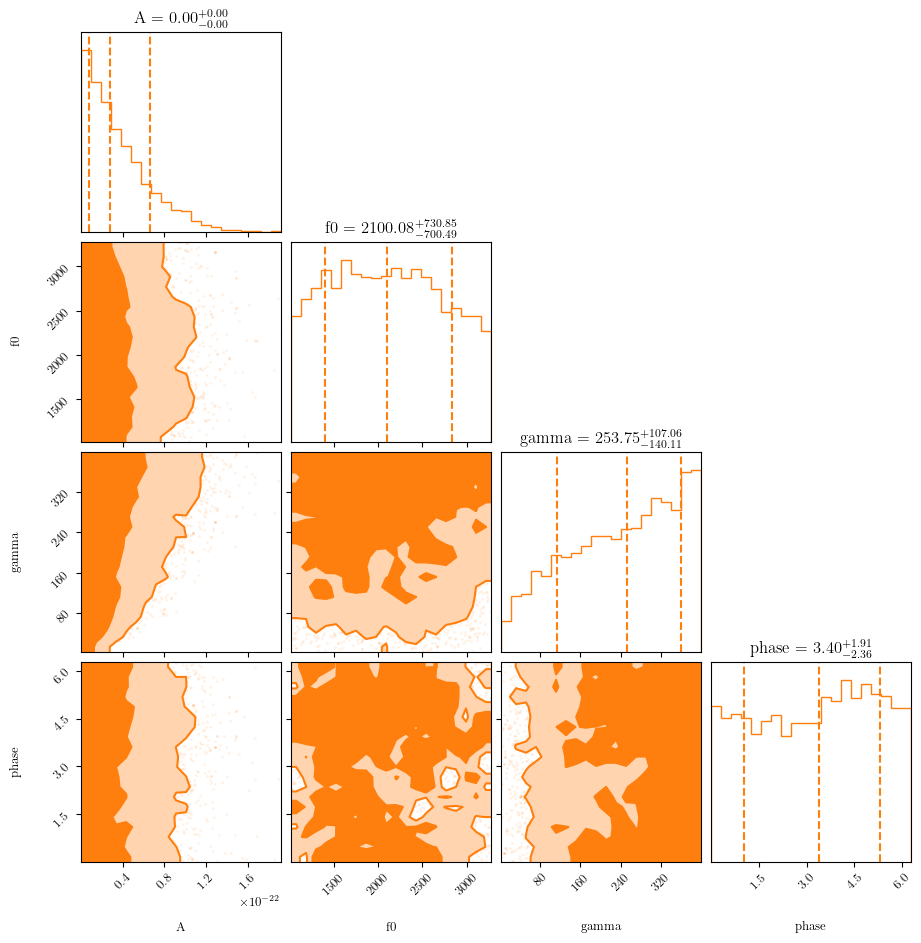

In [12]:
from corner import corner
corner(data, plot_density=False, smooth=0.6, fill_contours=True, levels=[0.68, 0.95], color='C1', quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, hist_kwargs={'histtype': 'step', 'color': 'C1'})
plt.show()

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>],
       [<AxesSubplot: title={'center': 'phase'}>,
        <AxesSubplot: title={'center': 'phase'}>]], dtype=object)

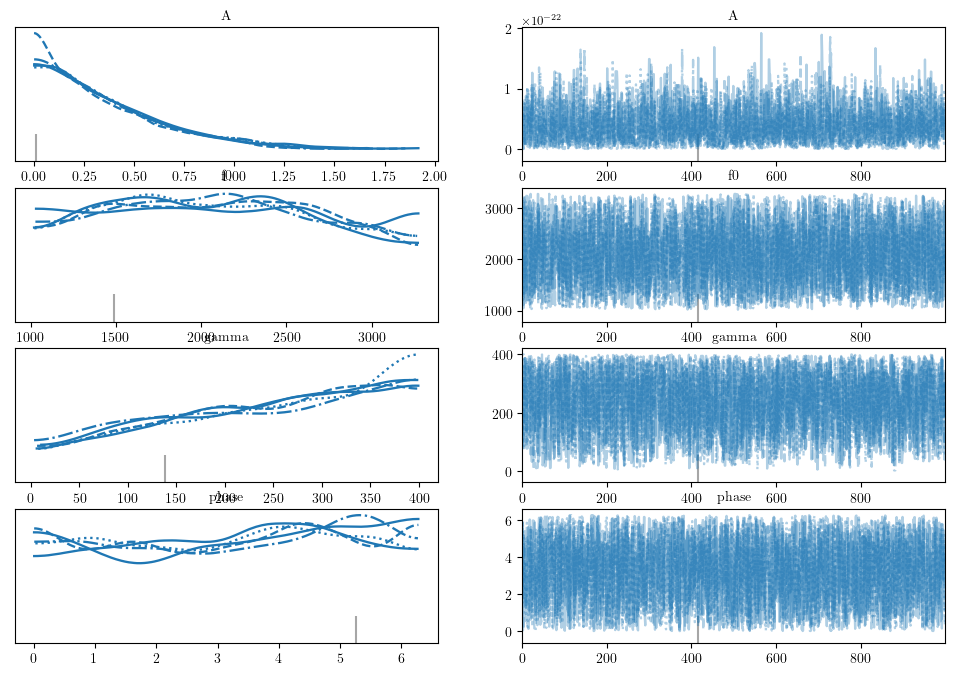

In [13]:
az.plot_trace(data)

In [ ]:
i=941 #5, 916
file = f'results_250403b_CE1CE2silica/result_{1000 + i}_pc.nc'
#file='/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/results_250401_CE1CE2silica/no_detection_pc.nc'
data = az.from_netcdf(file)
dataset = np.genfromtxt(f'/home/ethan.payne/projects/GWPhotonCounting/projects/PM_EOS/hierarchical_EOS/bns_pm_dataset_updated.dat')
mtots, z, phi, psi, ra, dec, iota, fpeak_true, snr, snr_silica, snr_silicon = dataset[1000 + i]

In [ ]:
f0s = data.posterior.f0.values.flatten()
np.random.shuffle(f0s)
f0s = f0s[:5000]

(array([645., 522., 462., 440., 435., 399., 347., 287., 227., 208., 186.,
        169., 113., 103.,  78.,  65.,  48.,  42.,  41.,  42.,  21.,  32.,
         27.,  28.,  33.]),
 array([ 550.00764011,  596.50003294,  642.99242576,  689.48481858,
         735.9772114 ,  782.46960422,  828.96199704,  875.45438987,
         921.94678269,  968.43917551, 1014.93156833, 1061.42396115,
        1107.91635397, 1154.40874679, 1200.90113962, 1247.39353244,
        1293.88592526, 1340.37831808, 1386.8707109 , 1433.36310372,
        1479.85549654, 1526.34788937, 1572.84028219, 1619.33267501,
        1665.82506783, 1712.31746065]),
 <BarContainer object of 25 artists>)

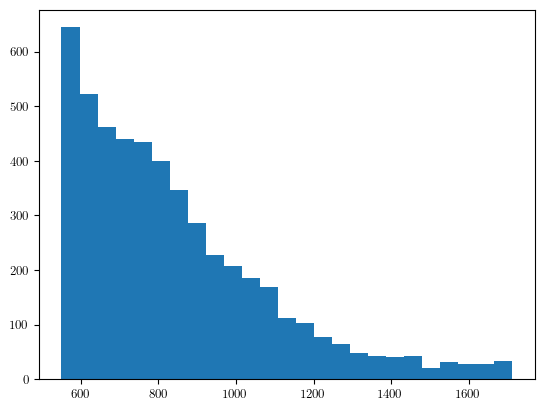

In [ ]:
plt.hist(f0s, bins=25)

In [ ]:
def invert_frequency_model(mtot, frequency):
    # Constants
    beta0 = 1.5220
    beta1 = 8.4021
    beta2 = 2.3876
    beta3 = -1.1133
    beta4 = -0.1291
    beta5 = 0.0366

    # Compute mchirp
    mchirp = mtot * 0.435  # equal mass assumption

    # Coefficients for the quadratic equation A*x^2 + B*x + C = 0
    A = beta5 * mchirp
    B = beta3 * mchirp + beta4 * mchirp**2
    C = beta0 + beta1 * mchirp + beta2 * mchirp**2 - frequency / 1e3

    # Discriminant
    discriminant = B**2 - 4*A*C

    # Solve using quadratic formula
    sqrt_disc = jnp.sqrt(discriminant)
    R1d6_1 = (-B + sqrt_disc) / (2*A)
    R1d6_2 = (-B - sqrt_disc) / (2*A)

    # Pick the physically meaningful root (positive and reasonable size)
    return R1d6_2

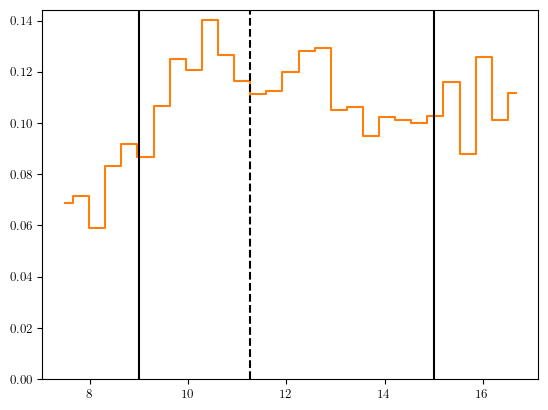

In [ ]:
R1d6_samples = invert_frequency_model(mtots, f0s*(1+z))
good_indexes = jnp.logical_and(R1d6_samples > 7.5, R1d6_samples < 17)
R1d6_samples = R1d6_samples[good_indexes]
weight_noise = interp1d(jnp.linspace(1e2, 4e3, 100), np.exp(hierarchical_analysis.likelihood_noise_only_pc), kind='linear', fill_value='extrapolate')(f0s[good_indexes])

concat_array = np.concatenate([R1d6_samples, 2*7.5 - R1d6_samples, 2*17 - R1d6_samples])
concat_weights = np.concatenate([1/GWPhotonCounting.hierarchical.frequency_model_derivative(mtots, R1d6_samples)/weight_noise, 
                                 1/GWPhotonCounting.hierarchical.frequency_model_derivative(mtots, R1d6_samples)/weight_noise, 
                                 1/GWPhotonCounting.hierarchical.frequency_model_derivative(mtots, R1d6_samples)/weight_noise])

kde_result = gaussian_kde(concat_array, weights=concat_weights, bw_method=1/(len(f0s))**0.2)(np.linspace(9,15,1000))


density = np.histogram(concat_array, bins=np.linspace(7.5,17,30), density=True, weights=concat_weights)[0]

plt.step(np.linspace(7.5,17,30)[:-1], density, where='mid', label='Weighted KDE', color='C1')
plt.ylim(0,)
plt.axvline(11.27, color='k', linestyle='--', label='APR4 R1.6')
plt.axvline(9, color='k')
plt.axvline(15, color='k')

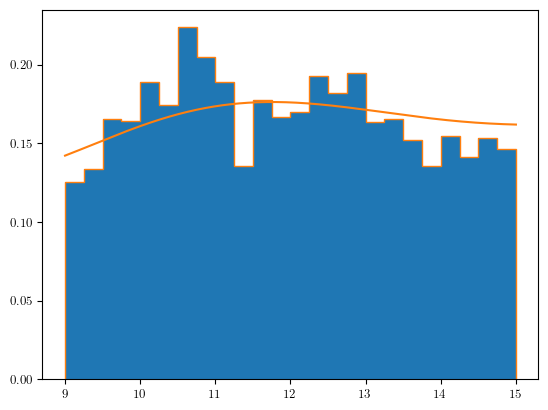

In [ ]:
plt.hist(R1d6_samples, weights=1/GWPhotonCounting.hierarchical.frequency_model_derivative(mtots, R1d6_samples)/weight_noise, density=True, bins=np.linspace(9,15,25))
plt.hist(concat_array, weights=concat_weights, density=True, bins=np.linspace(9,15,25), histtype='step', color='C1')
plt.plot(np.linspace(9,15,1000), kde_result/np.sum(kde_result)/(6/1e3), color='C1', label='KDE')

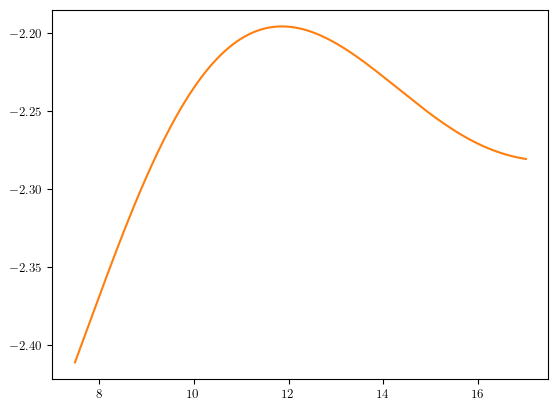

In [ ]:
plt.plot(np.linspace(7.5,17,1000), jnp.log(kde_result/np.sum(kde_result)/(9.5/1e3)), color='C1', label='KDE')